In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from math import pi
import os

def generate_radar_plots(file_path):
    # --- Parse filename for saving
    base_filename = os.path.splitext(os.path.basename(file_path))[0]
    output_dir = "figures"
    os.makedirs(output_dir, exist_ok=True)

    # --- Load and parse
    df = pd.read_csv(file_path, delimiter=';')
    result_columns = ['VL', 'pre_post', 'pre', 'post', 'pre_VL_post', 'pre_VL', 'VL_post']
    
    def parse_result_column(value):
        try:
            return ast.literal_eval(value)
        except Exception:
            return {}

    for col in result_columns:
        df[col] = df[col].apply(parse_result_column)

    records = []
    for _, row in df.iterrows():
        vuln_type = row["vulnerability_type"]
        for strategy in result_columns:
            data = row[strategy]
            if isinstance(data, dict):
                records.append({
                    "Vulnerability_Type": vuln_type,
                    "Strategy": strategy,
                    "Regression Test Success": int(data.get("Sanity_Test_Success", False)),
                    "Vulnerability Patched": int(data.get("Exploit_Covered", False)),
                    "Accepted Patch": int(data.get("Sanity_Test_Success", False) and data.get("Exploit_Covered", False))
                })

    long_df = pd.DataFrame(records)
    grouped = long_df.groupby(["Vulnerability_Type", "Strategy"]).sum().reset_index()

    radar1_grouped = grouped.groupby("Vulnerability_Type")[["Regression Test Success", "Vulnerability Patched", "Accepted Patch"]].sum().reset_index()
    radar2_grouped = grouped.groupby("Strategy")[["Regression Test Success", "Vulnerability Patched", "Accepted Patch"]].sum().reset_index()

    best_strategy_per_vuln = (
        grouped.loc[grouped.groupby("Vulnerability_Type")["Accepted Patch"].idxmax()]
        [["Vulnerability_Type", "Strategy", "Accepted Patch"]]
    )

    radar1_enriched = radar1_grouped.merge(best_strategy_per_vuln, on="Vulnerability_Type", suffixes=('', '_best'))
    radar1_enriched.rename(columns={"Accepted Patch_best": "Best Strategy Accepted Patch"}, inplace=True)


    # --- Plotting functions
    def plot_radar_multi_clean(ax, labels, data, title, colors):
        N = len(labels)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]
        for i, metric in enumerate(data.columns[1:]):
            values = data[metric].tolist()
            values += values[:1]
            ax.plot(angles, values, linewidth=2, linestyle='solid', label=metric, color=colors[i])
            ax.fill(angles, values, alpha=0.1, color=colors[i])
            for j, val in enumerate(values[:-1]):
                ax.text(angles[j], val + 2, str(val), ha='center', va='bottom', fontsize=9, color='black', fontweight='normal')
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=11)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_title(title, y=1.1, fontsize=14)
        ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.25), fontsize=11, frameon=False)
        ax.spines["polar"].set_visible(False)

    def plot_radar_with_best_strategy_offset(ax, labels, data, title, colors):
        N = len(labels)
        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]
        for i, metric in enumerate(data.columns[1:4]):
            values = data[metric].tolist()
            values += values[:1]
            ax.plot(angles, values, linewidth=2, linestyle='solid', label=metric, color=colors[i])
            ax.fill(angles, values, alpha=0.1, color=colors[i])
            for j, val in enumerate(values[:-1]):
                ax.text(angles[j], val + 2, str(val), ha='center', va='bottom', fontsize=9, color='black', fontweight='normal')
        max_radius = max(data[["Regression Test Success", "Vulnerability Patched", "Accepted Patch"]].max())
        #count = data.iloc[i]["Accepted Patch_best"]
        count = data.iloc[i]["Best Strategy Accepted Patch"]

        #custom_offsets = [23, 24, 43, 32, 23, 23, 31, -28, 28] # to change the offset of the labels (bold strategy names)
        custom_offsets = [28, 29, 55, 37, 28, 28, 36, -28, 33]  
        for i, label in enumerate(labels):
            strategy = data.iloc[i]["Strategy"]
            #count = data.iloc[i]["Accepted Patch_best"]
            count = data.iloc[i]["Best Strategy Accepted Patch"]


            angle = angles[i]
            offset = custom_offsets[i % len(custom_offsets)] + max_radius
            ax.text(angle, offset, f'{strategy}\n({count})', ha='center', va='center', fontsize=9, color='black', fontweight='bold')
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(labels, fontsize=11)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_title(title, y=1.1, fontsize=14)
        ax.legend(loc='upper right', bbox_to_anchor=(1.35, 1.25), fontsize=11, frameon=False)
        ax.spines["polar"].set_visible(False)

    # --- Plot and save
    fig1, ax1 = plt.subplots(subplot_kw=dict(polar=True), figsize=(8, 7))
    plot_radar_with_best_strategy_offset(
        ax1,
        radar1_enriched["Vulnerability_Type"],
        radar1_enriched,
        f"", # Best Strategy per Vulnerability Type ({base_filename})
        ['#a6d854', '#66c2a5', '#8da0cb']
    )
    fig1.tight_layout()
    fig1_path = os.path.join(output_dir, f"{base_filename}_radar_best_strategy.pdf")
    fig1.savefig(fig1_path, format="pdf")
    plt.close(fig1)

    fig2, ax2 = plt.subplots(subplot_kw=dict(polar=True), figsize=(8, 7))
    plot_radar_multi_clean(
        ax2,
        radar2_grouped["Strategy"],
        radar2_grouped,
        f"", #Patch Performance by Strategy ({base_filename})
        ['#a6d854', '#66c2a5', '#8da0cb']
    )
    fig2.tight_layout()
    fig2_path = os.path.join(output_dir, f"{base_filename}_radar_strategy_performance.pdf")
    fig2.savefig(fig2_path, format="pdf")
    plt.close(fig2)

    return fig1_path, fig2_path

### Plotting the figures for two sets of validation experiments




In [5]:
def plot_figures(list_of_csv_files):
    fig_paths = []
    for file_path in list_of_csv_files:
        fig1_path, fig2_path = generate_radar_plots(file_path)
        fig_paths.append((fig1_path, fig2_path))
        print("Saved plots:", fig1_path, fig2_path)
    return fig_paths


IndexError: single positional indexer is out-of-bounds

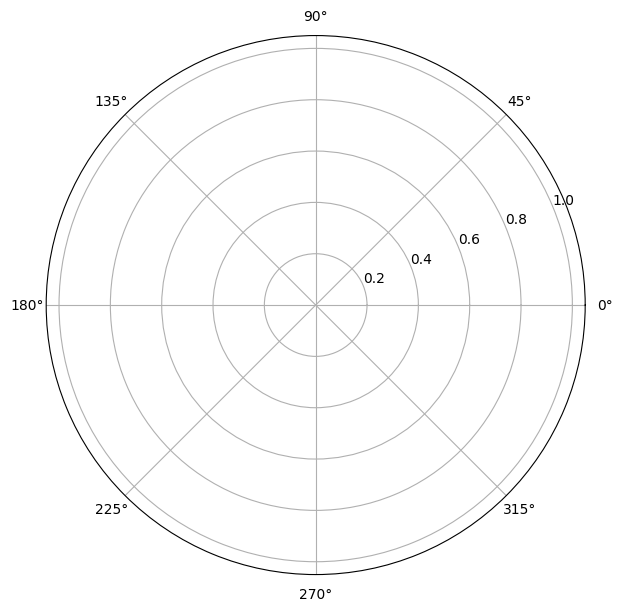

In [8]:
plot_figures([
    # "data/validation_results_CL_aggregated.csv",
    # "data/validation_results_100K_aggregated.csv",
    # "data/validation_results_20K_aggregated.csv",
    "data/aggregated/validation_results_DeepSeek_aggregated.csv"
])

In [ ]:
plot_figures([
    "data/validation_results_CL_isolated.csv",
    "data/validation_results_100K_isolated.csv",
    "data/validation_results_20K_isolated.csv",
])